In [1046]:
from mintpy.utils import *
import mintpy.utils as mpu
from mintpy.utils import readfile, writefile, ptime, utils as ut, arg_group
import mintpy.ifgram_inversion as ifgram_inversion
import mintpy.objects as mpo
import mintpy.ifgram_reconstruction as ifgram_reconstruction
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import os
from scipy.ndimage import convolve, correlate
import rasterio

In [1047]:
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")
# sns.set_theme(style="white") #, font_scale=0.5)
plt.style.use(['seaborn-paper', 'seaborn-ticks'])
sns.set_color_codes()

In [1048]:
matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['axes.linewidth']
plt.style.available
# matplotlib.use("pgf")
# matplotlib.rcParams.update({    
#     'font.family': 'serif',
#     'font.serif': [],       # use latex default serif font
#     'font.sans-serif': [],  # use a specific sans-serif font
#     'font.monospace': [],   # use a specific sans-serif font
#     'text.usetex': True,
#     'pgf.rcfonts': False,
#     'pgf.texsystem': 'pdflatex',
#     'lines.linewidth': 0.7,
#     'axes.linewidth': 0.6,
#     'axes.unicode_minus': False
# })

golden_ratio = (5**.5 - 1) / 2

# width  = 3.48761
width = 5
height = width*golden_ratio
print(width,height)

5 3.0901699437494745


In [1049]:
x_hi = 27.17121709587778 
x_lo = 27.207008492972506 
y_hi = 38.46679733384794
y_lo = 38.44770922788257

In [1050]:
x_hi,x_lo,y_hi,y_lo

(27.17121709587778, 27.207008492972506, 38.46679733384794, 38.44770922788257)

In [1051]:
AOI = 'POLYGON((27.17121709587778 38.46679733384794,27.207008492972506 38.46679733384794,27.207008492972506 38.44770922788257,27.17121709587778 38.44770922788257,27.17121709587778 38.46679733384794))'

> ağır hasarlı - Severely damaged
>
> yiklims - detroyed
>
> kismin yiklims - partly destroyed

In [1052]:
anc_int = rasterio.open('/data1/data/sar_izmir/izmir_data/20201012.tif')
pre_int = rasterio.open('/data1/data/sar_izmir/izmir_data/20201024.tif')
pst_int = rasterio.open('/data1/data/sar_izmir/izmir_data/20201105.tif')

In [1053]:
anc_int_VV = anc_int.read(2)
pre_int_VV = pre_int.read(2)
pst_int_VV = pst_int.read(2)

In [1054]:
win_size = 9
weights = np.ones((win_size,win_size))/(win_size**2)

In [1055]:
anc_int_VV = correlate(anc_int_VV, weights)
pre_int_VV = correlate(pre_int_VV, weights)
pst_int_VV = correlate(pst_int_VV, weights)

In [1056]:
anc_int_VV[:-1:2] += anc_int_VV[1::2]
anc_int_VV[:,:-1:2] += anc_int_VV[:,1::2]
anc_int_VV = anc_int_VV[::2,::2]/4

pre_int_VV[:-1:2] += pre_int_VV[1::2]
pre_int_VV[:,:-1:2] += pre_int_VV[:,1::2]
pre_int_VV = pre_int_VV[::2,::2]/4

pst_int_VV[:-1:2] += pst_int_VV[1::2]
pst_int_VV[:,:-1:2] += pst_int_VV[:,1::2]
pst_int_VV = pst_int_VV[::2,::2]/4

anc_int_VV_db = (np.log10(anc_int_VV)/10)
pre_int_VV_db = (np.log10(pre_int_VV)/10)
pst_int_VV_db = (np.log10(pst_int_VV)/10)

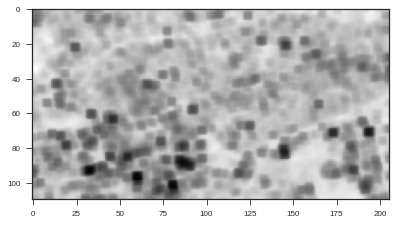

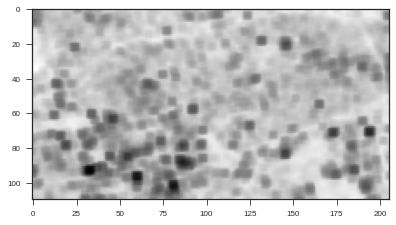

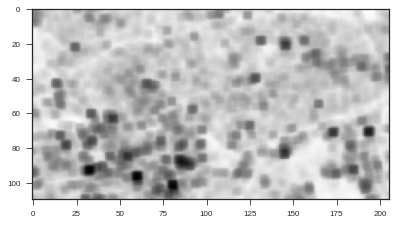

In [1057]:
plt.imshow(anc_int_VV_db)
plt.show()
plt.imshow(pre_int_VV_db)
plt.show()
plt.imshow(pst_int_VV_db)
plt.show()

In [1058]:
tm_des = rasterio.open('/data1/data/sar_izmir/izmir_data/tmmob_destroyed_mask.tif')
tm_pde = rasterio.open('/data1/data/sar_izmir/izmir_data/tmmob_part_destroyed_mask.tif')
tm_dam = rasterio.open('/data1/data/sar_izmir/izmir_data/tmmob_damaged_mask.tif')
el_des = rasterio.open('/data1/data/sar_izmir/izmir_data/elif_mask.tif')

In [1059]:
tm_des_mask = tm_des.read(1).astype(int)
tm_pde_mask = tm_pde.read(1).astype(int)
tm_dam_mask = tm_dam.read(1).astype(int)
el_des_mask = el_des.read(1).astype(int)

In [1060]:
tm_des_mask[::2] += tm_des_mask[1::2]
tm_des_mask[:,::2] += tm_des_mask[:,1::2]
tm_des_mask = tm_des_mask[::2,::2] > 1

tm_pde_mask[::2,] += tm_pde_mask[1::2,]
tm_pde_mask[:,::2] += tm_pde_mask[:,1::2]
tm_pde_mask = tm_pde_mask[::2,::2] > 1

tm_dam_mask[::2,] += tm_dam_mask[1::2,]
tm_dam_mask[:,::2] += tm_dam_mask[:,1::2]
tm_dam_mask = tm_dam_mask[::2,::2] > 2

el_des_mask[::2,] += el_des_mask[1::2,]
el_des_mask[:,::2] += el_des_mask[:,1::2]
el_des_mask = el_des_mask[::2,::2] > 1

In [1061]:
tm_des_mask.shape

(110, 206)

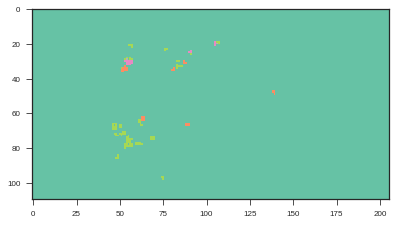

In [1062]:
plt.imshow(tm_des_mask*1 + tm_pde_mask*2 + tm_dam_mask*3, cmap='Set2', interpolation='none');
plt.show();

Get Extent

In [1063]:
full_mask = (tm_des_mask.astype(bool) | tm_pde_mask.astype(bool) ).astype(int)
# full_mask = (tm_des_mask.astype(bool)).astype(int)

In [1064]:
buffer = 5
xl, xr = (-1*(full_mask.sum(axis=0)>0)).argmin()-buffer, (full_mask.sum(axis=0)>0).cumsum().argmax()+buffer
yt, yb = (-1*(full_mask.sum(axis=1)>0)).argmin()-buffer, (full_mask.sum(axis=1)>0).cumsum().argmax()+buffer

In [1065]:
xl, xr, yt, yb

(46, 144, 14, 72)

In [1066]:
ye = slice(int(yt),int(yb))
xe = slice(int(xl),int(xr))

In [1067]:
# tm_dam_mask.astype(bool) | el_des_mask.astype(bool) 
# damage_mask = ( tm_des_mask.astype(bool) | el_des_mask.astype(bool) ).astype(int)[ye,xe]
# damage_mask = ( tm_pde_mask.astype(bool) | tm_des_mask.astype(bool) ).astype(int)[ye,xe]
# damage_mask = ( tm_pde_mask.astype(bool) | tm_des_mask.astype(bool) | el_des_mask.astype(bool) ).astype(int)[ye,xe]
damage_mask = ( tm_dam_mask.astype(bool) | tm_pde_mask.astype(bool) | tm_des_mask.astype(bool) | el_des_mask.astype(bool) ).astype(int)[ye,xe]

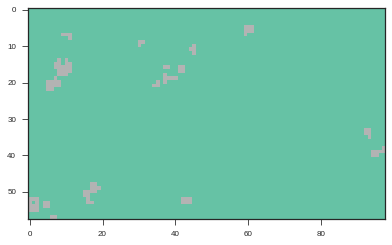

In [1068]:
plt.imshow(damage_mask, cmap='Set2', interpolation='none');
plt.show();

In [1069]:
mintpydir = '/data1/data/sar_izmir/mintpy_17/izmir/'

In [1070]:
#mask_data, mask_attr = mpu.readfile.read(os.path.join(mintpydir,'waterMask.h5'))

In [1071]:
# ifgram_file = ifgram_reconstruction.timeseries2ifgram('/data1/data/sar_izmir/mintpy/izmir/timeseries.h5',
#                                                       '/data1/data/sar_izmir/mintpy/izmir/inputs/ifgramStack.h5',
#                                                       '/tmp/reconUnwrapIfgram.h5')

In [1072]:
# rec_stack_obj = mpo.ifgramStack('/tmp/reconUnwrapIfgram.h5')
# rec_stack_obj.open(print_msg=False)
# rec_stack_obj.datasetNames

In [1073]:
# rec_ifgam = rec_stack_obj.read('unwrapPhase')
# rec_ifgam.shape

In [1074]:
stack_obj = mpo.ifgramStack(os.path.join(mintpydir,'inputs','ifgramStack.h5'))
stack_obj.open(print_msg=False)
stack_obj.datasetNames

['unwrapPhase', 'coherence', 'magnitude']

In [1075]:
ifgram = stack_obj.read('unwrapPhase')
ifgram.shape

reading unwrapPhase data from file: /data1/data/sar_izmir/mintpy_17/izmir/inputs/ifgramStack.h5 ...


(75, 110, 206)

In [1076]:
rst_shp = ifgram.shape[1:]
rst_shp

(110, 206)

In [1077]:
ts_rec, atr_rec = mpu.readfile.read(os.path.join(mintpydir,'timeseries.h5'))
#included = pre_dat_idx
def getSubRecIgram(ts, atr, included=None):
    range2phase = -4.*np.pi / float(atr['WAVELENGTH'])
    ts_data = ts * range2phase
    num_date, length, width = ts_data.shape
    ts_data = ts_data.reshape(num_date, -1)

    G_new = G.copy()
    include = (G_new[:,included] != 0)*stack_obj.dropIfgram

    ifgram_est = np.dot(G_new[include,0:num_date], ts_data).reshape(G_new[include,0:num_date].shape[0], length, width)    
    pha_data = np.array(ifgram_est, dtype=ts_data.dtype)

    pha_data[np.isnan(pha_data)] = 0.

    rec_ifgram = pha_data
    return rec_ifgram, include[stack_obj.dropIfgram]

In [1078]:
def ROC(dmp_ups, damage_mask, debug=False):
    res_TP = []
    res_FP = []
    len_dmp = len(dmp_ups.flatten())
    DS = damage_mask.sum()
    for i in np.linspace(dmp_ups.max(),dmp_ups.min(), 1000):
        P = (dmp_ups>=i)
        P_sum = P.sum()
        N = (dmp_ups<i)
        N_sum = len_dmp - P_sum
        TP = (P*damage_mask).sum()
        FP = P_sum - TP
        FN = (N*damage_mask).sum()
        TN = N.sum() - FN        
        TPR = TP/(TP+FN) #if P_sum > 0 else 0
        FPR = FP/(FP+TN) #if N_sum > 0 else 0
        res_TP.append(TPR)
        res_FP.append(FPR)
        if debug:
            print(TP, FP, P_sum, N_sum, TPR, FPR)
    return (np.array(res_FP), np.array(res_TP))

In [1079]:
date_list = stack_obj.get_date_list(dropIfgram=True)
num_date = len(date_list)
tbase = np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25
tbase_diff = np.diff(tbase).reshape(-1, 1)

In [1080]:
date_idx = {d:i for i, d in enumerate(date_list)}
date_idx

{'20200801': 0,
 '20200813': 1,
 '20200825': 2,
 '20200906': 3,
 '20200918': 4,
 '20200930': 5,
 '20201012': 6,
 '20201024': 7,
 '20201105': 8}

In [1081]:
anc_dat_idx = date_idx['20201012']
pre_dat_idx = date_idx['20201024'] 
pst_dat_idx = date_idx['20201105']
anc_dat_idx, pre_dat_idx, pst_dat_idx

(6, 7, 8)

In [1082]:
# design matrix
date12_list_G = stack_obj.get_date12_list(dropIfgram=False)
G = stack_obj.get_design_matrix4timeseries(date12_list_G, refDate='no')[0]
date12_list = stack_obj.get_date12_list(dropIfgram=True)
A, B = stack_obj.get_design_matrix4timeseries(date12_list=date12_list, refDate='no')[0:2]

In [1083]:
date12_idx = {d:i for i, d in enumerate(date12_list)}
date12_idx

{'20200801_20200813': 0,
 '20200801_20200825': 1,
 '20200801_20200906': 2,
 '20200801_20200918': 3,
 '20200813_20200825': 4,
 '20200813_20200906': 5,
 '20200825_20200906': 6,
 '20200825_20201012': 7,
 '20200906_20200918': 8,
 '20200906_20200930': 9,
 '20200906_20201012': 10,
 '20200906_20201024': 11,
 '20200918_20200930': 12,
 '20200918_20201012': 13,
 '20200918_20201024': 14,
 '20200918_20201105': 15,
 '20200930_20201012': 16,
 '20200930_20201024': 17,
 '20200930_20201105': 18,
 '20201012_20201024': 19,
 '20201012_20201105': 20,
 '20201024_20201105': 21}

In [1084]:
coh_data = ifgram_inversion.read_coherence(stack_obj,
                                           None,
                                           dropIfgram=True).reshape((-1,)+rst_shp)

nef_phase = stack_obj.get_reference_phase(unwDatasetName='unwrapPhase',
                                          skip_reference=True,
                                          dropIfgram=True)
int_data = ifgram_inversion.read_unwrap_phase(stack_obj,
                                              None, 
                                              nef_phase, 
                                              obs_ds_name='magnitude', 
                                              dropIfgram=True).reshape((-1,)+rst_shp)

ref_phase = stack_obj.get_reference_phase(unwDatasetName='unwrapPhase',
                                          skip_reference=False,
                                          dropIfgram=True)
pha_data = ifgram_inversion.read_unwrap_phase(stack_obj,
                                              None, 
                                              ref_phase, 
                                              obs_ds_name='unwrapPhase', 
                                              dropIfgram=True).reshape((-1,)+rst_shp)
ifgram = pha_data.reshape(A.shape[0], -1)

reading coherence in None * 22 ...
skip checking reference pixel info - This is for offset and testing ONLY.
reading magnitude in None * 22 ...
use input reference phase
reference pixel in y/x: (102, 25) from dataset: unwrapPhase
reading unwrapPhase in None * 22 ...
use input reference phase


In [1085]:
anc_ses_idx = date12_idx['20200918_20201024']; 
pre_ses_idx = date12_idx['20201012_20201024']; 
pst_ses_idx = date12_idx['20201024_20201105'];
anc_ses_idx, pre_ses_idx, pst_ses_idx

(14, 19, 21)

In [1086]:
win_size = 5
weights = np.ones((win_size,win_size)) #/(win_size**2)

In [1087]:
pre_coh_old = correlate(coh_data[pre_ses_idx], np.ones((win_size,win_size))/(win_size**2))
pre_coh_old.mean()

0.6376092

In [1088]:
cos_coh_old = correlate(coh_data[pst_ses_idx], np.ones((win_size,win_size))/(win_size**2))
cos_coh_old.mean()

0.61276346

In [1089]:
pha_pre_ses = np.angle(np.exp(1j*pha_data[pre_ses_idx]))
pha_pst_ses = np.angle(np.exp(1j*pha_data[pst_ses_idx]))
pha_pre_ses.min(), pha_pre_ses.max(), pha_pre_ses.mean(), pha_pst_ses.min(), pha_pst_ses.max(), pha_pst_ses.mean()

(-3.1082954, 3.0868664, -0.35563186, -3.140911, 3.1412108, -0.7526514)

In [1090]:
ts, atr = mpu.readfile.read(os.path.join(mintpydir,'timeseries_ERA5_demErr.h5'))
range2phase = -4.*np.pi / float(atr['WAVELENGTH'])
ts_data = ts * range2phase

In [1091]:
class Inps:
    pass
inps = Inps()
inps.ifgramStackFile = '/data1/data/sar_izmir/mintpy_17/izmir/inputs/ifgramStack.h5'
inps.obsDatasetName = 'magnitude'
inps.minNormVelocity = False
inps.minRedundancy = 1
inps.weightFunc = 'no'
inps.maskDataset= False
inps.tsFile = '/tmp/timeseries.h5'
inps.invQualityFile = '/tmp/temporalCoherence.h5'
inps.numInvFile = '/tmp/numInvIfgram.h5'
inps.maskThreshold = 0.0
inps.maxMemory = 8 #GB
inps.waterMaskFile = False 
inps.cluster = False
inps.skip_ref = True

In [1092]:
!rm /tmp/timeseries.h5
ifgram_inversion.ifgram_inversion(inps)

skip checking reference pixel info - This is for offset and testing ONLY.
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation phase
minimum redundancy: 1
weight function: no
mask: no
-------------------------------------------------------------------------------
number of interferograms: 22
number of acquisitions  : 9
number of lines   : 110
number of columns : 206
--------------------------------------------------
create HDF5 file: /tmp/timeseries.h5 with w mode
create dataset  : date       of |S8                       in size of (9,)                 with compression = None
create dataset  : bperp      of <class 'numpy.float32'>   in size of (9,)                 with compression = None
create dataset  : timeseries of <class 'numpy.float32'>   in size of (9, 110, 206)        with compression = None
close  HDF5 file: /tmp/timeseries.h5
--------------------------------------------------
create HDF5 file: 

In [1093]:
date12_diag = ["{}_{}".format(a,b) for a,b in zip(date_list[0:-1], date_list[1:])]

In [1094]:
date12_didx = [date12_idx[i] for i in date12_diag]

In [1095]:
ts_int_data, atr_int = mpu.readfile.read(os.path.join('/tmp/','timeseries.h5'))
ts_int_data[1:] -= ts_int_data[:-1]
ts_int_data[1:,:,:] += int_data[date12_didx].mean(axis=(1,2)).reshape(-1,1,1) - ts_int_data[1:].mean(axis=(1,2)).reshape(-1,1,1)

In [1096]:
ts_int_data[1:].max(axis=(1,2))

array([360.74902, 364.34778, 350.63593, 353.8498 , 358.8352 , 351.61902,
       354.72845, 360.12604], dtype=float32)

In [1097]:
ts_int_data[1:].min(axis=(1,2))

array([317.338  , 319.43787, 326.4997 , 324.1176 , 319.61285, 320.88867,
       321.72906, 308.53387], dtype=float32)

In [1098]:
int_data[date12_didx].max(axis=(1,2))

array([385.4835 , 381.91608, 385.92596, 381.71692, 381.38696, 384.89267,
       385.33496, 386.5571 ], dtype=float32)

In [1099]:
int_data[date12_didx].min(axis=(1,2)) 

array([308.1876 , 309.24088, 311.44757, 303.08258, 307.92654, 304.40433,
       293.4514 , 298.45697], dtype=float32)

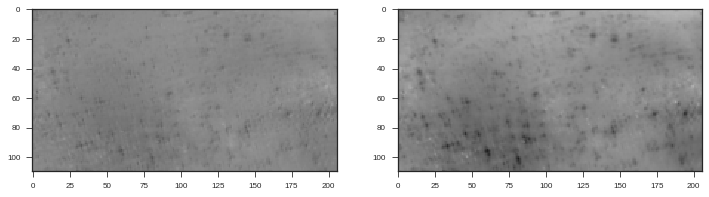

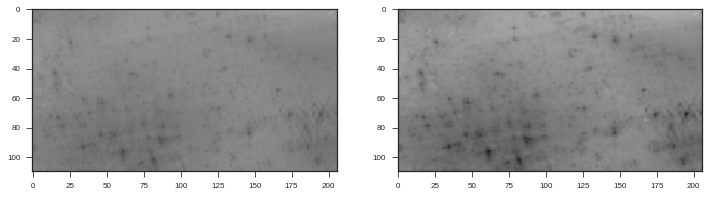

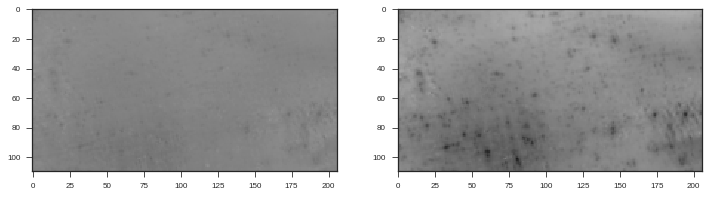

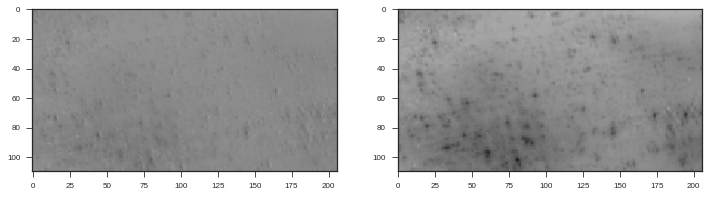

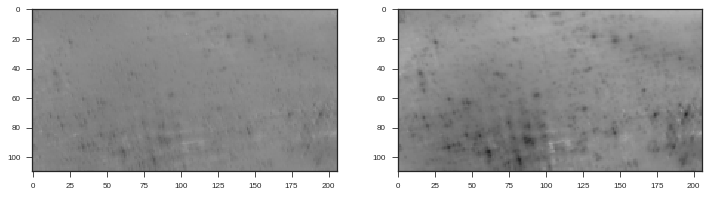

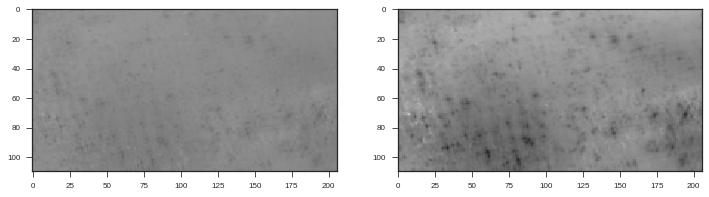

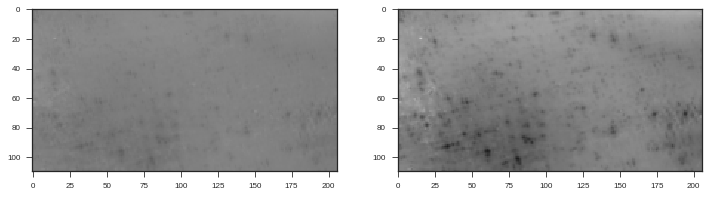

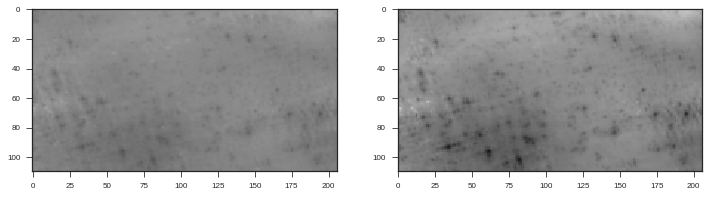

In [1100]:
for r, q in zip(ts_int_data[1:], int_data[date12_didx]):
    plt.figure(figsize=(12,8))
    plt.subplot(121)
    plt.imshow(r,interpolation='none',vmin=250.00,vmax=400.00)
    plt.subplot(122)
    plt.imshow(q,interpolation='none',vmin=250.00,vmax=400.00)

In [1101]:
int_anc_ses = (10**(ts_int_data[anc_dat_idx]/20))**0.5
int_pre_ses = (10**(ts_int_data[pre_dat_idx]/20))**0.5
int_pst_ses = (10**(ts_int_data[pst_dat_idx]/20))**0.5

int_anc_ses_db = ts_int_data[anc_dat_idx]
int_pre_ses_db = ts_int_data[pre_dat_idx]
int_pst_ses_db = ts_int_data[pst_dat_idx]

In [1102]:
int_anc_ses.max(), int_pre_ses.max(),int_pst_ses.max()

(617271000.0, 738264060.0, 1007281660.0)

In [1103]:
ts_anc_ses = np.angle(np.exp(1j*ts_data[anc_dat_idx]))
ts_pre_ses = np.angle(np.exp(1j*ts_data[pre_dat_idx]))
ts_pst_ses = np.angle(np.exp(1j*ts_data[pst_dat_idx]))
ts_pre_ses.min(), ts_pre_ses.max(), ts_pre_ses.mean(), ts_pst_ses.min(), ts_pst_ses.max(), ts_pst_ses.mean()

(-3.1395233, 3.1406078, -0.124637045, -3.1414757, 3.1412685, -0.19708642)

In [1104]:
win_size = 5
weights = np.ones((win_size,win_size)) #/(win_size**2)

In [1105]:
pre_coh_new = np.abs(correlate(anc_int_VV*pre_int_VV*np.exp(1j*(ts_pre_ses)), weights) \
                     / (np.sqrt(correlate(anc_int_VV**2, weights))*np.sqrt(correlate(pre_int_VV**2,weights)))
                    )
pre_coh_new.min(), pre_coh_new.max(), pre_coh_new.mean()

(0.49016634, 0.99823135, 0.96569777)

In [1106]:
cos_coh_new = np.abs(correlate(pre_int_VV*pst_int_VV*np.exp(1j*(ts_pst_ses)), weights) \
                     / (np.sqrt(correlate(pre_int_VV**2, weights))*np.sqrt(correlate(pst_int_VV**2,weights)))
                    )
cos_coh_new.min(), cos_coh_new.max(), cos_coh_new.mean()

(0.45554513, 0.9983004, 0.95502406)

In [1107]:
subrec_ifgram, include = getSubRecIgram(ts_rec, atr_rec, pre_dat_idx)
ifgram_diff = ifgram[include].reshape(subrec_ifgram.shape) - subrec_ifgram
inv_quality = np.abs(np.sum(np.exp(1j*ifgram_diff), axis=0))/include.sum()
tem_pre_coh = inv_quality.reshape(ts.shape[1:3])

In [1108]:
subrec_ifgram, include = getSubRecIgram(ts_rec, atr_rec, pst_dat_idx)
ifgram_diff = ifgram[include].reshape(subrec_ifgram.shape) - subrec_ifgram
inv_quality = np.abs(np.sum(np.exp(1j*ifgram_diff), axis=0))/include.sum()
tem_cos_coh = inv_quality.reshape(ts.shape[1:3])

In [1109]:
coh_data_cor = []
for c in coh_data[date12_didx]:
    coh_data_cor.append(  correlate(c, np.ones((win_size,win_size))/(win_size**2)) )
coh_data_cor = np.asarray(coh_data_cor)

In [1180]:
dmps = {}
# https://www.mdpi.com/2072-4292/10/8/1318/htm
hist = (coh_data[-2:-1] - coh_data_cor[:-2])
hist_men = hist.mean(axis=0)
hist_std = hist.std(axis=0)
pres = coh_data_cor[-2:-1].mean(axis=0)
cost = coh_data_cor[-1:].mean(axis=0)

dmps['hist'] = ((pres - cost) - (hist_men + 3*hist_std)) #* ((pres-cost)<=0.5).astype(int)
dmps['base'] = (pres - cost)
# dmps['smth'] = (pre_coh_old - cos_coh_old)
# dmps['ours'] = (pre_coh_new - curt)
dmps['ours+'] = (pre_coh_new*tem_pre_coh  - curt)
dmps['ours++'] = ((0.5*pre_coh_old + 0.5*pre_coh_new)*pre_coh - cos_coh_old)

# # dmps['bins'] = (pre_int_VV/pst_int_VV)
# dmps['ints'] = (int_pre_ses/int_pst_ses)
# dmps['ints+'] = (int_pre_ses/int_pst_ses) + (pre_coh_new*pre_coh - cos_coh_old)

# dmps['elev'] = (ts[-2]-ts[-2].min())/(ts[-1]-ts[-1].min()+0.00001)

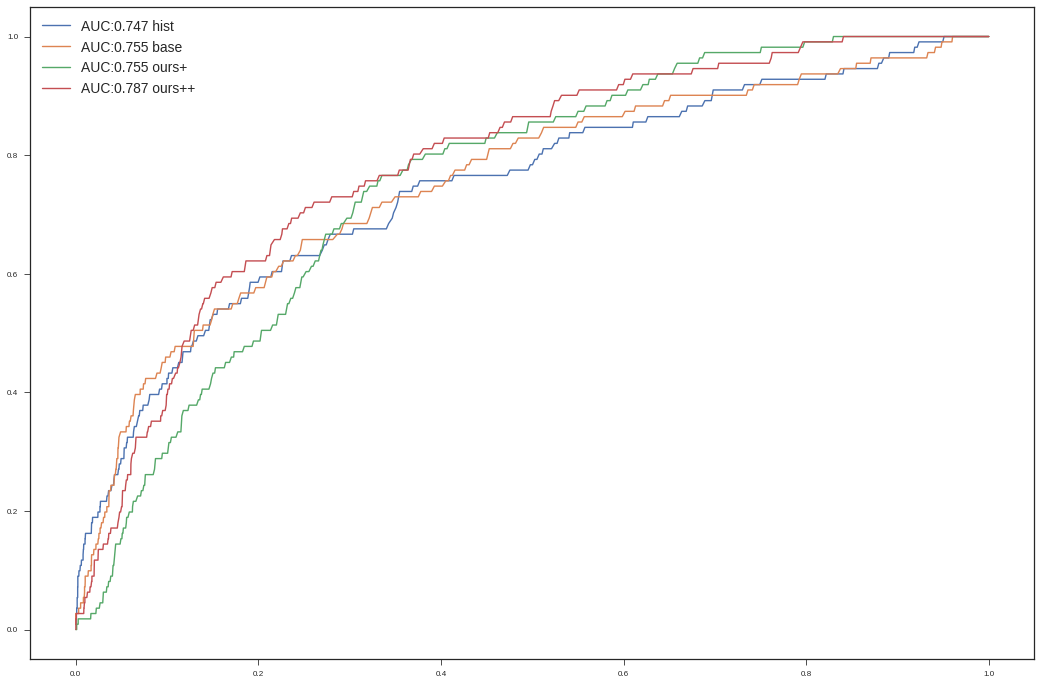

In [1181]:
plt.figure(figsize=(18,12))
for k, dmp in dmps.items():
    dmp_ups = dmp[ye,xe]
    x,y = ROC(dmp_ups, damage_mask)
    dx = x.copy()
    dx[1:] -= dx[0:-1]    
    plt.plot(x,y,label='AUC:{:0.3} {} '.format((dx*y).sum(),k));
plt.legend(fontsize='x-large');

In [ ]:
dmp = dmps['ints+'].copy()

In [ ]:
dmp_ups = dmp[ye,xe]
dmp_ups -= dmp_ups.mean()
dmp_ups /= dmp_ups.std()

In [ ]:
sns.displot(dmp_ups.flatten());

Upsample the dmp

In [ ]:
dmp_ups.shape

In [ ]:
# a,b = ROC(dmp_ups, damage_mask, True)

In [ ]:
i = 1.4
P = (dmp_ups>=i)
N = (dmp_ups<i)
TP = P*damage_mask
FP = P - TP
FN = N*damage_mask
TN = N - FN
TP.sum(), FP.sum(), FN.sum(), TN.sum(), len(dmp_ups.flatten())

In [ ]:
plt.figure(figsize=(20,8))
plt.imshow(1 + TP*2 + FP*6 + FN*3, interpolation='none', cmap='Accent', vmin=0, vmax=8)
plt.colorbar();

In [ ]:
# cell_size = 9
# test_size = 3
# cut = np.ones((cell_size,cell_size))
# cut[test_size:-test_size,test_size:-test_size] = 0
# num_train = cut.sum()
# cut /= cut.sum()
# rate_fa = 0.01
# alpha = (num_train)*(rate_fa**(-1/num_train) - 1)
# p_noise = correlate(dmps['ours'], cut)
# dmps['cut'] = dmps['ours']-p_noise